In [79]:
import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_new as utils
import scipy.stats as stats
import scipy
from sklearn.neighbors import KernelDensity

%config InlineBackend.figure_format='retina'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Difference in analysis between the results of this and the orignal work
Here we look at what causes our different interpretations in the 10um results.

In [56]:
pixelToM, frameToS = 0.106e-6, 0.08

In [63]:
data_dir = ['new_data/transformed_10um/']

file_dir = ['0224/mengqi_sel_10um.txt']

D_dir = ['mengqi_0518/mengqiD_10um.txt']

In [58]:
enzymes = utils.enzymeBayes(data_dir, ml=5)

23 files; 2620 trajectories (length >= 5); Total 24420 data points


MSD and random walk model reveals similar $D$ estimation

In [69]:
sel_ind = np.loadtxt(file_dir[0]).astype(int)
D = np.loadtxt(D_dir[0]) * frameToS / pixelToM**2

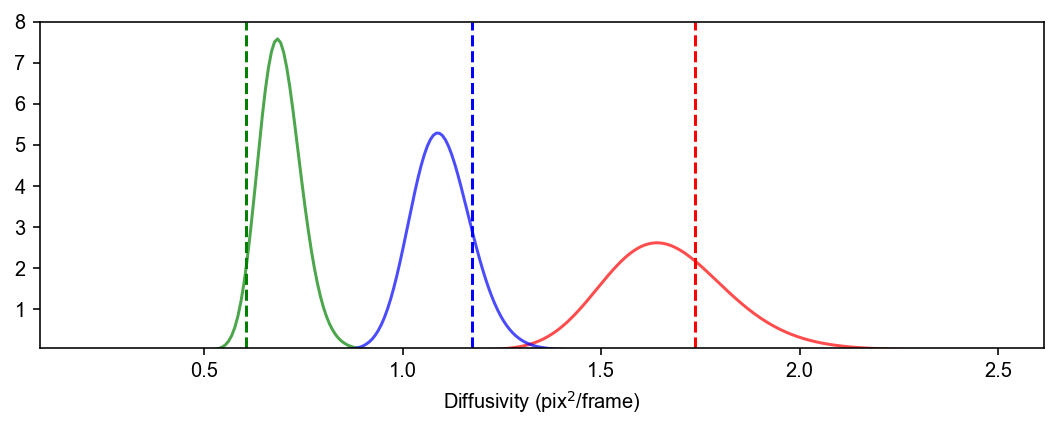

In [61]:
x_ = np.linspace(0.2, 2.5, 300)

plt.figure(figsize=(9, 3))
for ind, col in zip([10, 36, 59], ['r', 'g', 'b']):
    sx, sy, st = enzymes.loadSelectTraj(0, sel_ind[ind])

    sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
    s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
    a = 1 + len(sdx)
    b = 1 + s

    plt.plot(x_, stats.invgamma.pdf(x_, a=a, scale=b), c=col, alpha=0.7)
    plt.axvline(x=D[ind], c=col, ls='--',)
    
plt.ylim(0.05, 8)
plt.xlabel('Diffusivity (pix$^2$/frame)')
plt.show()

In the original work, individual msd estimation of $D$ is fitted with a lognormal distribution. Here, we compare this distribution with: 1. hierarhical bm. 2. hierarhical bm with larger minimum length. 3. hierarhical bm with larger minimum length and breakup at large $\tau$.

In [81]:
# add hierarhical 
map_hier = enzymes.computeHyperParams(0, sel_ind)

# impose larger minlength
ranking, tl, index, map_, avg_dt = enzymes.rank(0, sel_ind, ml=20)
map_hier_long = enzymes.computeHyperParams(0, index)

# breakup at large tau
tot_x, tot_y, tot_t, tot_track, tot_mom = [], [], [], [], []
temp_x, temp_y, temp_t, temp_track, temp_mom = [], [], [], [], []

for j in range(len(sel_ind)):
    sx, sy, st = enzymes.loadSelectTraj(0, sel_ind[j])
    temp_x.append(sx)
    temp_y.append(sy)
    temp_t.append(st)
    temp_track.append(len(sx))
    temp_mom.append(np.zeros((len(sx), 5)))
tot_x.append(np.concatenate(temp_x))
tot_y.append(np.concatenate(temp_y))
tot_t.append(np.concatenate(temp_t))
tot_mom.append(temp_mom)
tot_track.append(temp_track)
    
new_enzyme = utils.enzymeBayes(None, loadFromCvs=False, tot_x=tot_x, 
                              tot_y=tot_y, tot_t=tot_t, tot_track_info=tot_track, 
                                  tot_mom=tot_mom, BI=[3*np.ones((len(temp_track), ))])

new_enzyme.ignoreLongJump()
new_index = [i for i in range(len(new_enzyme.tot_track_info[0]))]
ranking, tl, index, map_, avg_dt = new_enzyme.rank(0, new_index, ml=20)
map_hier_long_jump = new_enzyme.computeHyperParams(0, index)

alpha = 2.136233, beta = 3.160124, optimize success = True
alpha = 2.374369, beta = 3.176815, optimize success = True
alpha = 2.778461, beta = 2.919221, optimize success = True


In [77]:
mean,std = scipy.stats.norm.fit(np.log(D))
plt.hist(np.log(D), bins=30)
xmin, xmax = plt.xlim()
plt.close()
x = np.linspace(xmin, xmax+1, 100)
y = scipy.stats.norm.pdf(x, mean, std)

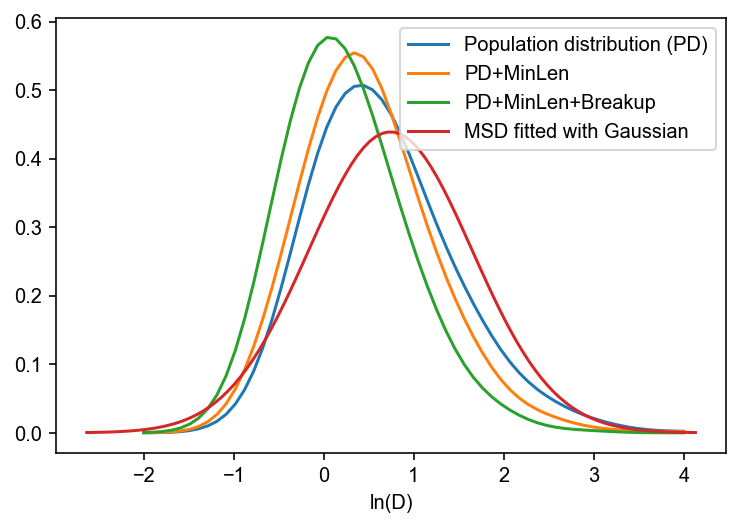

In [83]:
np.random.seed(56)
la = ['Population distribution (PD)', 'PD+MinLen', 'PD+MinLen+Breakup']

map_tot = [map_hier, map_hier_long, map_hier_long_jump]
bin_array = np.linspace(-2, 4, 60)

for i in range(3): 

    alpha_, beta_ = map_tot[i][0], map_tot[i][1]

    log_samples = np.log(stats.invgamma.rvs(a=alpha_, scale=beta_, size=4000))
    kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(log_samples.reshape(-1, 1))
    den = np.exp(kde.score_samples(bin_array[:, np.newaxis]))

    plt.plot(bin_array, den, label=la[i])
#     plt.hist(log_samples, bins=bin_array, density=True, alpha=0.5)
    
plt.plot(x, y, label='MSD fitted with Gaussian')
plt.legend()
plt.xlabel('ln(D)')
plt.show()